In [1]:
import os
import ROOT
from itertools import product

Welcome to JupyROOT 6.28/04


In [189]:
MEASURE = "mu"        # ele / mu
ERA     = "2018"
isDATA  = False
POGBASE = "/Users/choij/workspace/Materials/TagAndProbe"
TNPBASE = f"{os.getcwd()}/../results"

In [190]:
# bins
if MEASURE == "mu":
    etabin = [0., 0.9, 1.2, 2.1, 2.4]
    ptbin = [15, 20, 25, 30, 40, 50, 60, 120]
elif MEASURE == "ele" and ERA == "2016b":
    etabin = [-2.5, -2., -1.566, -1.4442, -0.8, 0., 0.8, 1.4442, 1.566, 2., 2.5]
    ptbin = [10., 20., 35., 50., 100., 500.]
else:
    etabin = [-2.5, -2., -1.566, -1.4442, -0.8, 0., 0.8, 1.4442, 1.566, 2., 2.5] 
    ptbin = [10., 20., 35., 50., 100., 200., 500.]

In [191]:
# make file map for each era
POGMAP_ele = {
    "2016a": f"{POGBASE}/Electron/egammaEffi.txt_Ele_wp90noiso_preVFP_EGM2D.root",
    "2016b": f"{POGBASE}/Electron/egammaEffi.txt_Ele_wp90noiso_postVFP_EGM2D.root",
    "2017": f"{POGBASE}/Electron/egammaEffi.txt_EGM2D_MVA90noIso_UL17.root",
    "2018": f"{POGBASE}/Electron/2018_ElectronMVA90noiso.root"
}
POGMAP_mu = {
    "2016a": f"{POGBASE}/Muon/Efficiencies_muon_generalTracks_Z_Run2016_UL_HIPM_ID.root",
    "2016b": f"{POGBASE}/Muon/Efficiencies_muon_generalTracks_Z_Run2016_UL_ID.root",
    "2017": f"{POGBASE}/Muon/Efficiencies_muon_generalTracks_Z_Run2017_UL_ID.root",
    "2018": f"{POGBASE}/Muon/Efficiencies_muon_generalTracks_Z_Run2018_UL_ID.root"
}

if MEASURE == "ele":
    POGMAP = POGMAP_ele
elif MEASURE == "mu":
    POGMAP = POGMAP_mu
else:
    print(f"wrong measure {MEASURE}")
    raise(KeyError)

def tnppath(measure, era):
    if measure == "ele":
        filepath = f"{TNPBASE}/POGElectron_V3/POGMVANoIsoWP90_{era}/efficiency.root"
    elif measure == "mu":
        filepath = f"{TNPBASE}/POGMuon_V0/NUM_POGMedium_DEN_TrackerMuons_{era}/efficiency.root"
    else:
        print("measure should be ele or mu")
        raise(KeyError)
    assert os.path.exists(filepath)
    
    return filepath

In [192]:
# get root file
f_pog = ROOT.TFile.Open(POGMAP[ERA])
f_tnp = ROOT.TFile.Open(tnppath(MEASURE, ERA))

In [193]:
# get histogram for estimation
def get_hist(measure, era, is_data, is_pog):
    meas_map = {
        "ele_data": "EGamma_EffData2D",
        "ele_mc": "EGamma_EffMC2D"
    }
    
    if is_pog:
        f = ROOT.TFile.Open(POGMAP[era])
        if measure == "ele" and is_data:
            h = f.Get("EGamma_EffData2D")
        elif measure == "ele" and not is_data:
            h = f.Get("EGamma_EffMC2D")
        elif measure == "mu" and is_data:
            h = f.Get("NUM_MediumID_DEN_TrackerMuons_abseta_pt_efficiencyData")
        elif measure == "mu" and not is_data:
            h = f.Get("NUM_MediumID_DEN_TrackerMuons_abseta_pt_efficiencyMC")
        else:
            raise(KeyError)
    else:
        f = ROOT.TFile.Open(tnppath(measure, era))
        if is_data:
            h = f.Get("data")
        else:
            h = f.Get("sim")
    h.SetDirectory(0)
    f.Close()
    return h

In [194]:
h_pog = get_hist(MEASURE, ERA, is_data=isDATA, is_pog=True)
h_tnp = get_hist(MEASURE, ERA, is_data=isDATA, is_pog=False)

Warning in <TH2D::Add>: Attempt to add histograms with different axis limits
Warning in <TH2D::Divide>: Dividing histograms with different axis limits
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cvs


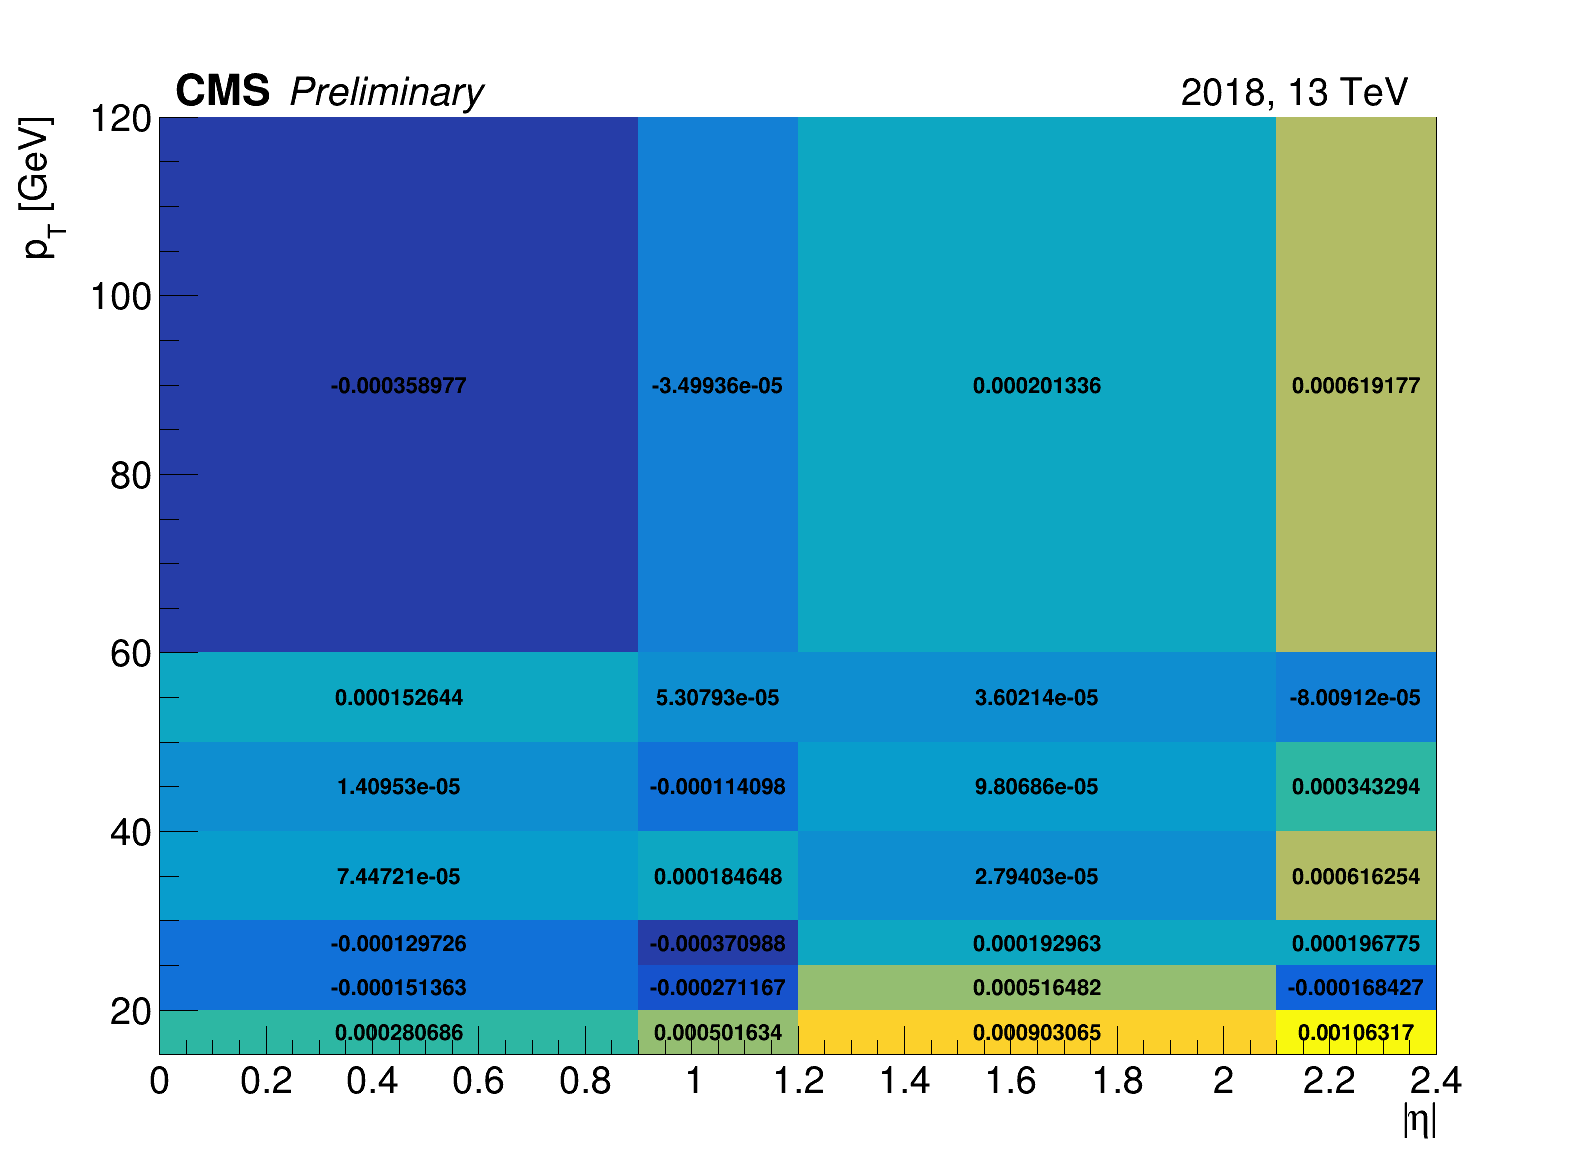

In [195]:
# make a difference mapping
h_diff = h_tnp.Clone("diff")
h_diff.Add(h_pog, -1)
h_diff.Divide(h_pog)

text = ROOT.TLatex()
def setCOMText():
    text.SetTextSize(0.035)
    text.SetTextFont(42)
    
def setCMSText():
    text.SetTextSize(0.04)
    text.SetTextFont(61)
    
def setWIPText():
    text.SetTextSize(0.036)
    text.SetTextFont(52)

c = ROOT.TCanvas("cvs", "", 1600, 1200)
c.cd()
h_diff.Draw("col&text")
setCOMText(); text.DrawLatexNDC(0.74, 0.91, f"{ERA}, 13 TeV")
setCMSText(); text.DrawLatexNDC(0.11, 0.91, "CMS")
setWIPText(); text.DrawLatexNDC(0.18, 0.91, "Preliminary")
c.Draw()

In [139]:
for bin, (pt, eta) in enumerate(product(ptbin[:-1], etabin[:-1])):
    eta, pt = eta+0.01, pt+0.01
    thisbin = h_pog.FindBin(eta, pt)
    eff_pog = h_pog.GetBinContent(thisbin)
    eff_tnp = h_tnp.GetBinContent(thisbin)
    print(f"[bin {bin}] \t{eff_pog:.4f}\t{eff_tnp:.4f}\t{(eff_tnp-eff_pog)/eff_pog*100:.2f}%")

[bin 0] 	0.9944	0.9947	0.03%
[bin 1] 	0.9936	0.9936	0.01%
[bin 2] 	0.9971	0.9970	-0.01%
[bin 3] 	0.9878	0.9882	0.03%
[bin 4] 	0.9943	0.9946	0.03%
[bin 5] 	0.9941	0.9943	0.02%
[bin 6] 	0.9968	0.9964	-0.04%
[bin 7] 	0.9852	0.9859	0.07%
[bin 8] 	0.9946	0.9946	0.01%
[bin 9] 	0.9946	0.9945	-0.01%
[bin 10] 	0.9969	0.9968	-0.01%
[bin 11] 	0.9862	0.9868	0.06%
[bin 12] 	0.9949	0.9952	0.03%
[bin 13] 	0.9955	0.9951	-0.03%
[bin 14] 	0.9971	0.9970	-0.01%
[bin 15] 	0.9877	0.9879	0.02%
[bin 16] 	0.9947	0.9949	0.02%
[bin 17] 	0.9959	0.9954	-0.05%
[bin 18] 	0.9975	0.9973	-0.02%
[bin 19] 	0.9889	0.9889	-0.00%
[bin 20] 	0.9943	0.9943	-0.00%
[bin 21] 	0.9955	0.9952	-0.03%
[bin 22] 	0.9978	0.9976	-0.01%
[bin 23] 	0.9889	0.9883	-0.07%
[bin 24] 	0.9934	0.9938	0.04%
[bin 25] 	0.9952	0.9937	-0.15%
[bin 26] 	0.9980	0.9980	-0.00%
[bin 27] 	0.9877	0.9892	0.14%
